
# Gaussian Processes regression: basic introductory example

A simple one-dimensional regression example computed in two different ways:

1. A noise-free case
2. A noisy case with known noise-level per datapoint

In both cases, the kernel's parameters are estimated using the maximum
likelihood principle.

The figures illustrate the interpolating property of the Gaussian Process model
as well as its probabilistic nature in the form of a pointwise 95% confidence
interval.

Note that `alpha` is a parameter to control the strength of the Tikhonov
regularization on the assumed training points' covariance matrix.

This workbook was borrowed heavily from scikit-learn.org


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Dataset generation

We will start by generating a synthetic dataset. The true generative process
is defined as $f(x) = x \sin(x)$.



In [2]:
# generate some data

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

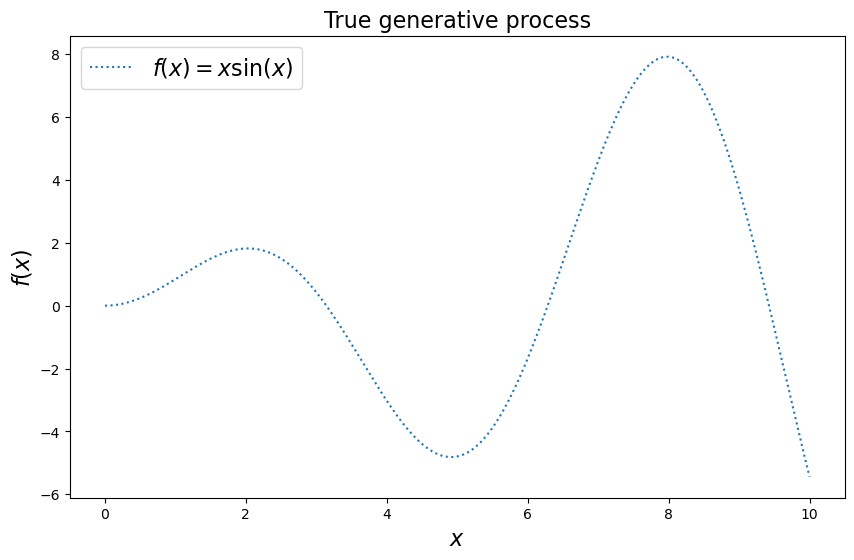

In [3]:
# plot
plt.figure(figsize=(10,6))
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend(fontsize=16)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
_ = plt.title("True generative process", fontsize=16)

We will use this dataset in the next experiment to illustrate how Gaussian
Process regression is working.

## Example with noise-free target

In this first example, we will use the true generative process without
adding any noise. For training the Gaussian Process regression, we will only
select few samples.



In [4]:
# generate some random numbers from a seed
# a seed means you can return the same random numbers if you generate them again

seed = 3
rng = np.random.RandomState(seed=seed)


# Use these random numbers to make random pretend measuremnets of the above defined function
#
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)

X_train, y_train = X[training_indices], y[training_indices]

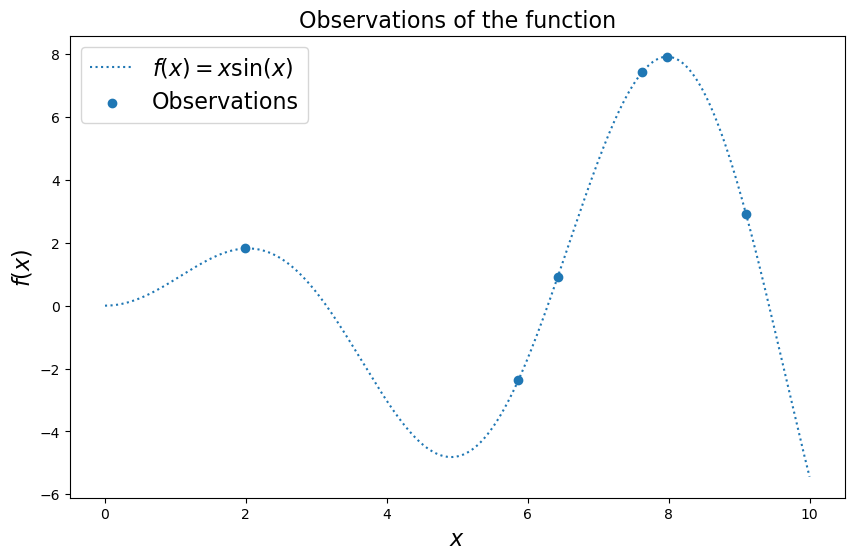

In [5]:
# make a plot of these observation locations
# if you use a different seed above, it will change the observation locations
plt.figure(figsize=(10,6))
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")

plt.legend(fontsize=16)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
_ = plt.title("Observations of the function", fontsize=16)

## Fit a GP to these measurements of the function

Now, we fit a Gaussian process on these few training data samples. We will
use a radial basis function (RBF) kernel and a constant parameter to fit the
amplitude.

## The RBF kernel

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# define the kernel. The '1' is for teh constant
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Perform the GP regression
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.27**2 * RBF(length_scale=1.44)

After fitting our model, we see that the hyperparameters of the kernel have
been optimized. Now, we will use our kernel to compute the mean prediction
of the full dataset and plot the 95% confidence interval.



## Predict mean and standard deviation

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

In [10]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

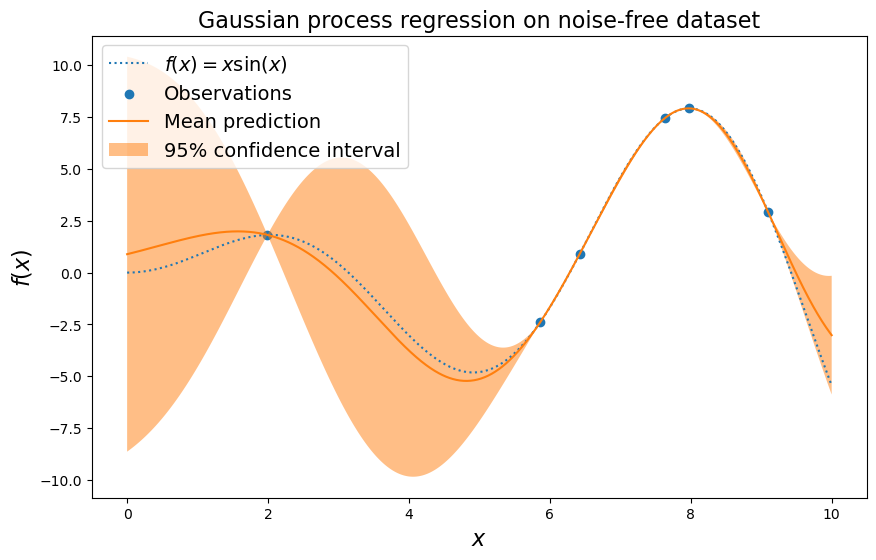

In [11]:
# plot
plt.figure(figsize=(10,6))
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend(fontsize=14)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
_ = plt.title("Gaussian process regression on noise-free dataset", fontsize=16)

We see that for a prediction made on a data point close to the one from the
training set, the 95% confidence has a small amplitude. Whenever a sample
falls far from training data, our model's prediction is less accurate and the
model prediction is less precise (higher uncertainty).

## Example with noisy targets

We can repeat a similar experiment adding an additional noise to the target
this time. It will allow seeing the effect of the noise on the fitted model.

This is often the case with real measuremnets of a variable - estimating their value has an uncertainty

We add some random Gaussian noise to the target with an arbitrary
standard deviation.



In [16]:
# generate some random numbers from a seed
# a seed means you can return teh same random numbers if you generate them again

seed = 3
rng = np.random.RandomState(seed=seed)


# Use these random numbers to make random pretend measuremnets of the above defined function
#
training_indices = rng.choice(np.arange(y.size), size=20, replace=False)

X_train, y_train = X[training_indices], y[training_indices]

In [17]:
# add noise to observation measurements (y)

noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

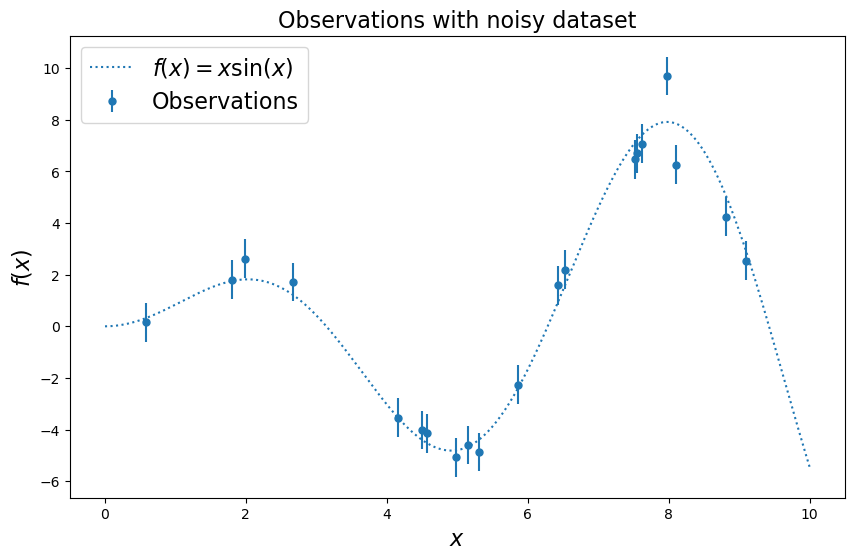

In [18]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)

plt.legend(fontsize=16)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
_ = plt.title("Observations with noisy dataset", fontsize=16)

We create a similar Gaussian process model. In addition to the kernel, this
time, we specify the parameter `alpha` which can be interpreted as the
variance of a Gaussian noise.



In [19]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

Let's plot the mean prediction and the uncertainty region as before.



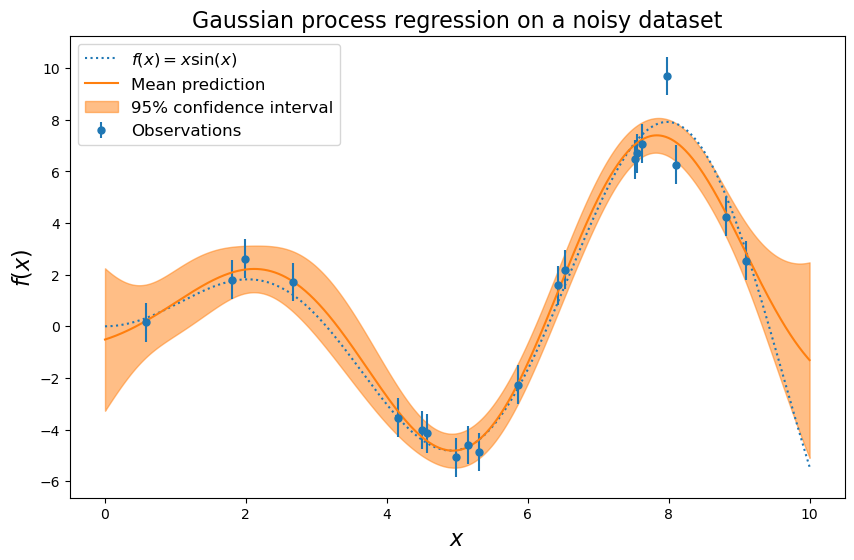

In [20]:
#Plot 
plt.figure(figsize=(10,6))
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend(fontsize=12)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
_ = plt.title("Gaussian process regression on a noisy dataset", fontsize=16)

The noise affects the predictions close to the training samples: the
predictive uncertainty near to the training samples is larger because we
explicitly model a given level target noise independent of the input
variable.



In [23]:
print(f"Kernel parameters before fit:\n{kernel})")
print(
    f"Kernel parameters after fit: \n{gaussian_process.kernel_} \n"
    f"Log-likelihood: {gaussian_process.log_marginal_likelihood(gaussian_process.kernel_.theta):.3f}"
)

Kernel parameters before fit:
1**2 * RBF(length_scale=1))
Kernel parameters after fit: 
4.47**2 * RBF(length_scale=1.54) 
Log-likelihood: -36.624


In [33]:
import matplotlib.pyplot as plt
import numpy as np


def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 5, 100)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.set_ylim([-10, 10])

Text(0.5, 1.0, 'Samples from prior distribution')

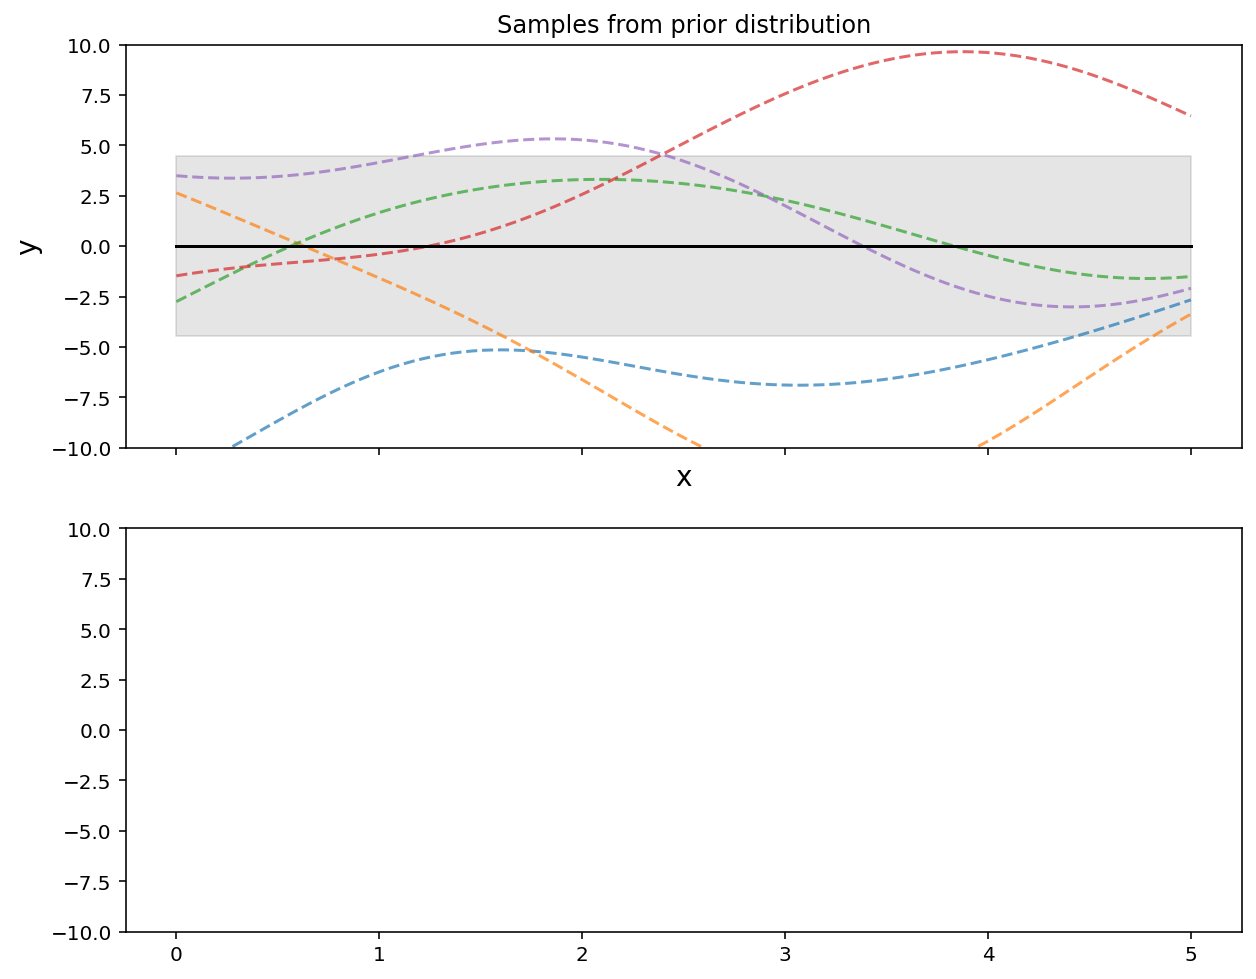

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 4.47**2 * RBF(length_scale=1.54, length_scale_bounds=(1e-1, 10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8), dpi=144)

# plot prior
# from untrained data
# call the function we defined above
# plot n_samples of that function
# plots the std dev of these 
plot_gpr_samples(gpr, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")